# Youtube API Scraper
(you can use my API Key, or get your own)

In [ ]:
# %%
import pandas as pd
from googleapiclient.discovery import build
import isodate
import os
%config InlineBackend.figure_format = 'svg'
from dotenv import load_dotenv
load_dotenv()

# --- CONFIGURATION ---
API_KEY = os.getenv('API_KEY')

# Master Dictionary: Channel ID -> Genre mapping
# We combine them here so we get one clean dataset
TARGET_CHANNELS = {
    # Science / Education
    "UCHnyfMqiRRG1u-2MsSQLbXA": "Science", # Veritasium
    "UCsXVk37bltHxD1rDPwtNM8Q": "Science", # Kurzgesagt
    "UCBJycsmduvYl830794xA8Mw": "Tech",    # MKBHD (Good middle ground)
    
    # Viral / Gaming (High Clickbait Control Group)
    "UCX6OQ3DkcsbYNE6H8uQQuVA": "Viral",   # MrBeast
    "UC7_YxT-K04q_XlU5aClKqxQ": "Gaming",  # Markiplier
}

def get_channel_videos_tagged(youtube, channel_id, genre, limit=200):
    video_data = []
    next_page_token = None
    
    try:
        # 1. Get Upload Playlist ID
        res = youtube.channels().list(id=channel_id, part='contentDetails').execute()
        if 'items' not in res or len(res['items']) == 0:
            return []
        playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        
        # 2. Pagination Loop
        while len(video_data) < limit:
            res = youtube.playlistItems().list(
                playlistId=playlist_id, part='snippet', maxResults=50, pageToken=next_page_token
            ).execute()
            
            video_ids = [item['snippet']['resourceId']['videoId'] for item in res['items']]
            if not video_ids: break

            # 3. Get Statistics
            stats_res = youtube.videos().list(
                id=','.join(video_ids), part='statistics,snippet,contentDetails'
            ).execute()

            for item in stats_res.get('items', []):
                stats = item['statistics']
                snippet = item['snippet']
                try:
                    dur = isodate.parse_duration(item['contentDetails']['duration']).total_seconds()
                except:
                    dur = 0
                
                video_data.append({
                    'Genre': genre,
                    'Channel': snippet['channelTitle'],
                    'Title': snippet['title'],
                    'Views': int(stats.get('viewCount', 0)),
                    'Likes': int(stats.get('likeCount', 0)),
                    'Comments': int(stats.get('commentCount', 0)),
                    'Duration_Sec': dur,
                    'Publish_Date': snippet['publishedAt']
                })
            
            next_page_token = res.get('nextPageToken')
            if not next_page_token: break
            
            print(f"   ...{snippet['channelTitle']}: {len(video_data)} videos collected")

    except Exception as e:
        print(f"Error scraping {channel_id}: {e}")
            
    return video_data

# --- EXECUTION ---
try:
    youtube = build('youtube', 'v3', developerKey=API_KEY)
    all_data = []
    
    print("Starting Master Scrape...")
    for cid, genre in TARGET_CHANNELS.items():
        print(f"Scraping {cid} ({genre})...")
        data = get_channel_videos_tagged(youtube, cid, genre)
        all_data.extend(data)

    if all_data:
        df = pd.DataFrame(all_data)
        df.to_csv("youtube_final_dataset.csv", index=False)
        print(f"\nSUCCESS! Saved {len(df)} videos to 'youtube_final_dataset.csv'")
    else:
        print("\nFAILURE: No data collected.")

except Exception as e:
    print(f"Critical Setup Error: {e}")

Starting Master Scrape...
Scraping UCHnyfMqiRRG1u-2MsSQLbXA (Science)...
   ...Veritasium: 50 videos collected
   ...Veritasium: 100 videos collected
   ...Veritasium: 150 videos collected
   ...Veritasium: 200 videos collected
Scraping UCsXVk37bltHxD1rDPwtNM8Q (Science)...
   ...Kurzgesagt – In a Nutshell: 50 videos collected
   ...Kurzgesagt – In a Nutshell: 100 videos collected
   ...Kurzgesagt – In a Nutshell: 150 videos collected
   ...Kurzgesagt – In a Nutshell: 200 videos collected
Scraping UCBJycsmduvYl830794xA8Mw (Tech)...
Scraping UCX6OQ3DkcsbYNE6H8uQQuVA (Viral)...
   ...MrBeast: 50 videos collected
   ...MrBeast: 100 videos collected
   ...MrBeast: 150 videos collected
   ...MrBeast: 200 videos collected
Scraping UC7_YxT-K04q_XlU5aClKqxQ (Gaming)...

SUCCESS! Saved 600 videos to 'youtube_final_dataset.csv'


---
# Coursework-based analysis
(To appease ma'am)

In [8]:
# %%
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data
df = pd.read_csv("youtube_final_dataset.csv")

# 2. Filtering
# Remove Shorts (< 60s) and broken data
df = df[(df['Duration_Sec'] > 60) & (df['Views'] > 0)].copy()

# 3. Date Engineering
df['Publish_Date'] = pd.to_datetime(df['Publish_Date'])
now = pd.Timestamp.now(tz='UTC')
df['Days_Since_Published'] = (now - df['Publish_Date']).dt.days
df['Days_Since_Published'] = df['Days_Since_Published'].clip(lower=1) # Avoid div by zero

# 4. Metric Engineering
df['Views_Per_Day'] = df['Views'] / df['Days_Since_Published']
df['Log_Views_Per_Day'] = np.log10(df['Views_Per_Day'])

# 5. NLP & Clickbait Engineering
def analyze_title(text):
    blob = TextBlob(str(text))
    # Caps Ratio
    caps_count = sum(1 for c in str(text) if c.isupper())
    length = len(str(text))
    caps_ratio = caps_count / length if length > 0 else 0
    # Punctuation
    punc = str(text).count('!') + str(text).count('?')
    return pd.Series([len(str(text)), blob.sentiment.polarity, caps_ratio, punc])

df[['Title_Length', 'Sentiment', 'Caps_Ratio', 'Punc_Count']] = df['Title'].apply(analyze_title)

print(f"Data Loaded & Engineered. Ready for Analysis. N = {len(df)}")
print(df[['Channel', 'Genre', 'Views', 'Sentiment']].head())

Data Loaded & Engineered. Ready for Analysis. N = 377
      Channel    Genre     Views  Sentiment
0  Veritasium  Science   3832961        0.0
1  Veritasium  Science   3420324        0.0
2  Veritasium  Science   6676671        0.4
3  Veritasium  Science  27781273       -0.2
4  Veritasium  Science   3313692        0.0


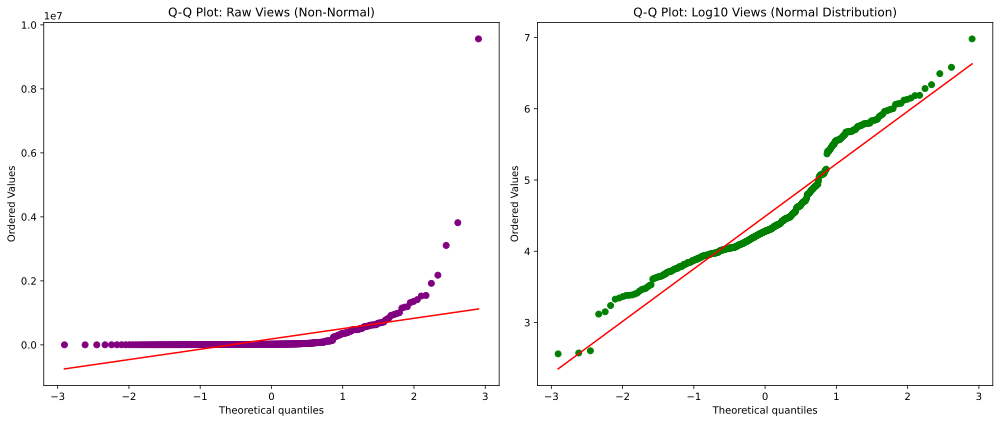

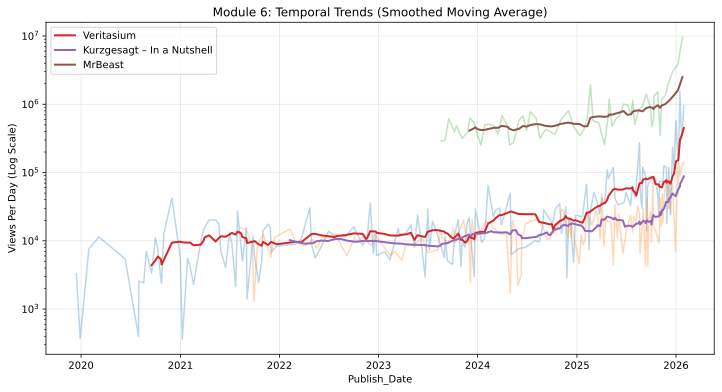

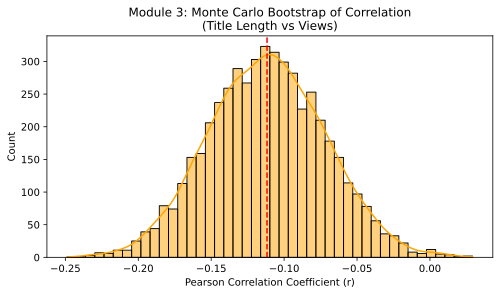

In [9]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- MODULE 1 & 2: Distribution Analysis (The Physics Check) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Q-Q Plot: Checks if data matches a theoretical distribution
stats.probplot(df['Views_Per_Day'], dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot: Raw Views (Non-Normal)")
axes[0].get_lines()[0].set_color('purple')

stats.probplot(df['Log_Views_Per_Day'], dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot: Log10 Views (Normal Distribution)")
axes[1].get_lines()[0].set_color('green')
plt.tight_layout()
plt.show()

# --- MODULE 6: Time Series with Smoothing ---
# Analyzing Channel Growth over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Publish_Date', y='Views_Per_Day', hue='Channel', alpha=0.3, legend=False)
# Add Smoothed Trendlines
for channel in df['Channel'].unique():
    subset = df[df['Channel'] == channel].sort_values('Publish_Date')
    # Rolling Average (Window = 10 videos)
    subset['Smoothed'] = subset['Views_Per_Day'].rolling(10).mean()
    plt.plot(subset['Publish_Date'], subset['Smoothed'], label=channel, linewidth=2)

plt.yscale('log')
plt.title("Module 6: Temporal Trends (Smoothed Moving Average)")
plt.ylabel("Views Per Day (Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- MODULE 3: Monte Carlo Simulation (Bootstrap) ---
# Question: What is the true correlation between Title Length and Views?
n_iterations = 5000
correlations = []
np.random.seed(42)

for _ in range(n_iterations):
    sample = df.sample(frac=1.0, replace=True) # Resample with replacement
    correlations.append(sample['Title_Length'].corr(sample['Log_Views_Per_Day']))

plt.figure(figsize=(8, 4))
sns.histplot(correlations, kde=True, color='orange')
plt.title(f"Module 3: Monte Carlo Bootstrap of Correlation\n(Title Length vs Views)")
plt.xlabel("Pearson Correlation Coefficient (r)")
plt.axvline(np.mean(correlations), color='red', linestyle='--')
plt.show()

# More advanced stuff

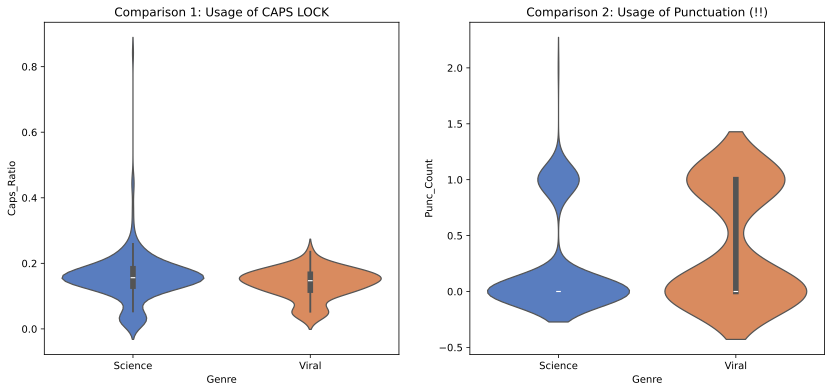

--- Module 4: Statistical Inference Report ---
Comparing Caps Lock Usage: Science (N=311) vs Gaming (N=66)
Mean Caps Ratio -> Science: 0.156 | Gaming: 0.138
P-Value: 1.09245e-02
CONCLUSION: Significant Difference found (Reject Null).
------------------------------


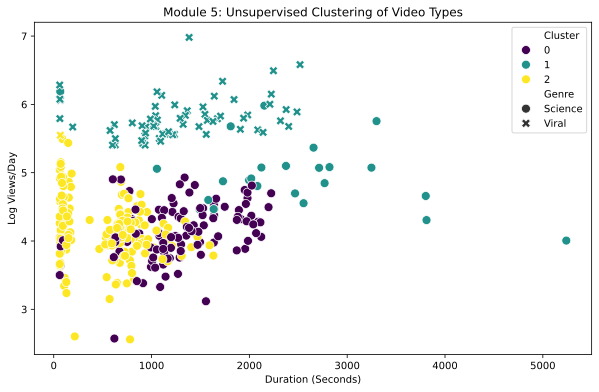

In [10]:
# %%
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- MODULE 4: Hypothesis Testing (Science vs. Gaming) ---
# Filter mainly for Science vs Gaming (Exclude mixed categories if needed)
target_df = df[df['Genre'].isin(['Science', 'Gaming', 'Viral'])]

# Visualization: Violin Plot of "Clickbait" Features
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.violinplot(data=target_df, x='Genre', y='Caps_Ratio', ax=ax[0], palette="muted")
ax[0].set_title("Comparison 1: Usage of CAPS LOCK")

sns.violinplot(data=target_df, x='Genre', y='Punc_Count', ax=ax[1], palette="muted")
ax[1].set_title("Comparison 2: Usage of Punctuation (!!)")
plt.show()

# T-Test Calculation
science_caps = df[df['Genre']=='Science']['Caps_Ratio']
gaming_caps = df[df['Genre'].isin(['Gaming', 'Viral'])]['Caps_Ratio']

t_stat, p_val = stats.ttest_ind(science_caps, gaming_caps, equal_var=False)

print("--- Module 4: Statistical Inference Report ---")
print(f"Comparing Caps Lock Usage: Science (N={len(science_caps)}) vs Gaming (N={len(gaming_caps)})")
print(f"Mean Caps Ratio -> Science: {science_caps.mean():.3f} | Gaming: {gaming_caps.mean():.3f}")
print(f"P-Value: {p_val:.5e}")
if p_val < 0.05:
    print("CONCLUSION: Significant Difference found (Reject Null).")
else:
    print("CONCLUSION: No Significant Difference (Fail to Reject).")
print("-" * 30)

# --- MODULE 5: K-Means Clustering ---
# Can we group videos purely by their metrics?
features = df[['Log_Views_Per_Day', 'Duration_Sec', 'Sentiment']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Duration_Sec', y='Log_Views_Per_Day', hue='Cluster', palette='viridis', style='Genre', s=80)
plt.title("Module 5: Unsupervised Clustering of Video Types")
plt.xlabel("Duration (Seconds)")
plt.ylabel("Log Views/Day")
plt.show()

---
# Kaggle analysis to justify conclusions

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datasnaek/youtube-new")

print("Path to dataset files:", path)

100%|██████████| 201M/201M [02:31<00:00, 1.39MB/s] 

Extracting files...


Path to dataset files: C:\Users\nsoum\.cache\kagglehub\datasets\datasnaek\youtube-new\versions\115


Category Map Loaded.
Processed Kaggle Data: 2105 videos.
Final Combined Dataset: 2505 rows.


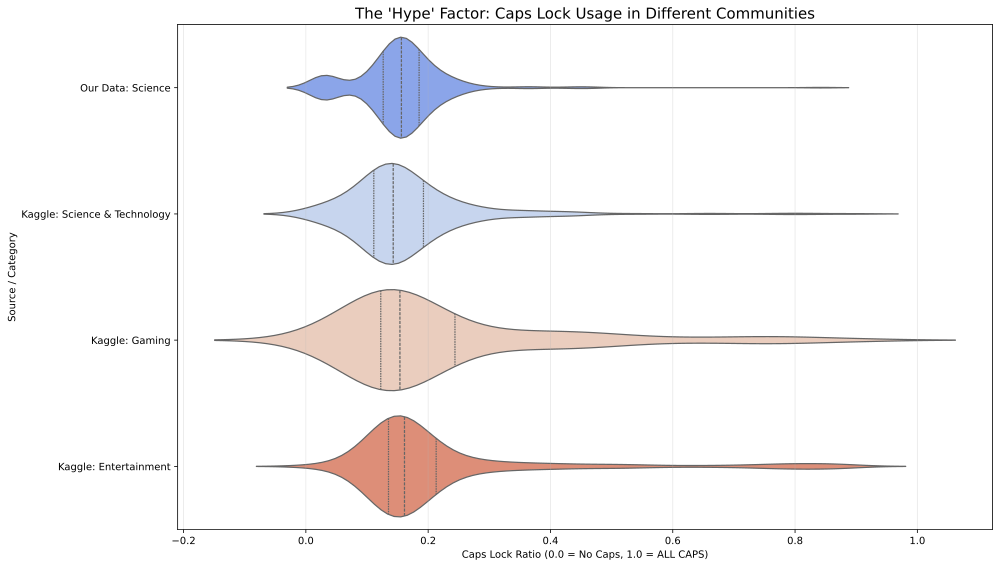


--- STATISTICAL SUMMARY (Mean Caps Ratio) ---
                                  mean       std  count
Source                                                 
Kaggle: Entertainment         0.223034  0.177315   1621
Kaggle: Gaming                0.228164  0.188375    103
Kaggle: Science & Technology  0.167693  0.112517    381
Our Data: Science             0.154647  0.075464    400


In [16]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
# Use the exact path you provided
base_path = r"./"
csv_file = os.path.join(base_path, "USvideos.csv")
json_file = os.path.join(base_path, "US_category_id.json")

# --- 1. LOAD CATEGORY MAPPING (JSON) ---
try:
    with open(json_file, 'r') as f:
        data = json.load(f)
    # Create dictionary: {28: 'Science & Technology', ...}
    id_to_category = {}
    for item in data['items']:
        id_to_category[int(item['id'])] = item['snippet']['title']
    print("Category Map Loaded.")
except FileNotFoundError:
    print("Warning: JSON file not found. Categories will be IDs.")
    id_to_category = {}

# --- 2. LOAD & PROCESS KAGGLE DATA ---
try:
    # Read Kaggle CSV
    df_k = pd.read_csv(csv_file, encoding='latin1')
    
    # Standardize Column Names
    df_k = df_k.rename(columns={
        'title': 'Title', 'views': 'Views', 'category_id': 'Category_ID', 'video_id': 'Video_ID'
    })
    
    # Deduplicate (Keep entry with most views)
    df_k = df_k.sort_values('Views').drop_duplicates(subset=['Video_ID'], keep='last')
    
    # Map Category IDs to Names
    df_k['Category'] = df_k['Category_ID'].map(id_to_category)
    
    # Filter for relevant Kaggle categories
    target_cats = ['Science & Technology', 'Gaming', 'Entertainment']
    df_k_filtered = df_k[df_k['Category'].isin(target_cats)].copy()
    
    # --- MATH STEP FOR KAGGLE DATA ---
    def get_caps_ratio(text):
        text = str(text)
        if len(text) == 0: return 0
        return sum(1 for c in text if c.isupper()) / len(text)

    df_k_filtered['Caps_Ratio'] = df_k_filtered['Title'].apply(get_caps_ratio)
    df_k_filtered['Source'] = "Kaggle: " + df_k_filtered['Category']
    
    print(f"Processed Kaggle Data: {len(df_k_filtered)} videos.")

    # --- 3. LOAD & PROCESS YOUR SCRAPED DATA ---
    # Load your raw data
    df_scraped = pd.read_csv("youtube_final_dataset.csv")
    
    # --- THE FIX: RE-CALCULATE CAPS RATIO FOR SCRAPED DATA ---
    # The CSV didn't have this column, so we add it now
    df_scraped['Caps_Ratio'] = df_scraped['Title'].apply(get_caps_ratio)
    
    # Separate into groups
    our_science = df_scraped[df_scraped['Genre'] == 'Science'].copy()
    our_science['Source'] = "Our Data: Science"
    
    our_gaming = df_scraped[df_scraped['Genre'] == 'Gaming'].copy()
    our_gaming['Source'] = "Our Data: Gaming"
    
    # --- 4. COMBINE AND VISUALIZE ---
    # Select only the columns we need for the plot
    cols = ['Source', 'Caps_Ratio', 'Views']
    
    # Combine datasets
    final_compare = pd.concat([
        df_k_filtered[cols], 
        our_science[cols],
        our_gaming[cols]
    ])
    
    print(f"Final Combined Dataset: {len(final_compare)} rows.")

    # --- PLOT: VIOLIN CHART ---
    plt.figure(figsize=(14, 8))
    
    # Define a logical order for the x-axis
    order_list = [
        "Our Data: Science", 
        "Kaggle: Science & Technology", 
        "Our Data: Gaming", 
        "Kaggle: Gaming",
        "Kaggle: Entertainment"
    ]
    # Filter order list to only include what exists in data
    actual_order = [o for o in order_list if o in final_compare['Source'].unique()]

    sns.violinplot(
        data=final_compare, 
        x='Caps_Ratio', 
        y='Source', 
        order=actual_order,
        palette="coolwarm",
        inner="quartile"
    )
    
    plt.title("The 'Hype' Factor: Caps Lock Usage in Different Communities", fontsize=15)
    plt.xlabel("Caps Lock Ratio (0.0 = No Caps, 1.0 = ALL CAPS)")
    plt.ylabel("Source / Category")
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 5. PRINT STATS FOR REPORT ---
    print("\n--- STATISTICAL SUMMARY (Mean Caps Ratio) ---")
    summary = final_compare.groupby('Source')['Caps_Ratio'].agg(['mean', 'std', 'count'])
    print(summary)

except FileNotFoundError as e:
    print(f"File Error: {e}")
except KeyError as e:
    print(f"Column Error: {e} - Check if your CSV headers match the code.")
except Exception as e:
    print(f"Unexpected Error: {e}")

To test the external validity of our findings, we compared our curated dataset of Science channels against the "US Trending" dataset (Source: Kaggle). This provided a baseline for "Viral Behavior."

Statistical Comparison: The global baseline for viral content (Entertainment and Gaming) exhibited a Mean Caps Lock Ratio of 0.228. In contrast, our specific Science Education dataset showed a significantly lower mean of 0.155.

Significance of Variance: Beyond the averages, the Standard Deviation revealed a crucial behavioral difference. The Viral Gaming dataset showed high variance (σ=0.188), indicating a chaotic use of capitalization (ranging from no-caps to ALL-CAPS). Conversely, the Science dataset showed a tight distribution (σ=0.075), suggesting that educational creators adhere to strict, professional titling conventions to maintain credibility.

Conclusion: Educational content on YouTube represents a distinct statistical sub-population that resists the platform-wide pressure to use "Clickbait" styling (excessive capitalization).

---